In [18]:
from svg.path import parse_path # requires svg.path: pip install svg.path
from svg.path.path import Line
from xml.dom import minidom
from PyPDF2 import PdfFileReader # requires PyPDF2: pip install PyPDF2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import os, sys
import os.path
import subprocess
from skfda import FDataGrid
import sklearn
from itertools import combinations
from skfda.ml.clustering import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import time
import math
import sklearn.cluster as sk
from skfda.preprocessing.dim_reduction.projection import FPCA
import statistics as st
from scipy import stats
import random
from skfda.misc.metrics import l2_distance, TransformationMetric, LpDistance, fisher_rao_distance
import hipoxia_clean_data as cd
import importlib
sys.path.append('dahfi_main/database_ctu-chb/')

from src.data import load_FHR_UC, load_targets, load_features_targets
from src.preprocessing import preprocessing_signals, remove_long_gaps, all_zero_move

In [26]:
importlib.reload(cd)

<module 'hipoxia_clean_data' from '/home/ejerez/Escritorio/UNI/QUINTO/Matrícula y TFGs/TFG/codigo/hipoxia_clean_data.py'>

Obtenemos los datos

In [27]:
target = load_targets(pH=7.2, path_csv='dahfi_main/database_ctu-chb/data/')
fd_fhr, fd_uc, target2 = cd.get_fhr_uc(target = target)

Loading data
Removing Nans
Transformation to FDataGrid


Como un primer intento, y con intención de reducir la dimensionalidad de los datos, probamos a realizar FPCA. Una buena representación de los datos en 2 o 3 dimensiones sería ideal y facilitaría mucho el análisis. 

In [22]:
for n_componentes in [2,3]:
    fpca_grid = FPCA(n_componentes)
    fpca_grid = fpca_grid.fit(fd_uc)
    # dp = fpca_grid.components_.plot()

    scores_uc = fpca_grid.transform(fd_uc)
    print("Varianza explicada con las %d primeras componentes para UC: %.4f" %(n_componentes, sum(fpca_grid.explained_variance_ratio_)))

    fpca_grid = FPCA(n_componentes)
    fpca_grid = fpca_grid.fit(fd_fhr)
    # dp = fpca_grid.components_.plot()

    scores_fhr = fpca_grid.transform(fd_fhr)

    print("Varianza explicada con las %d primeras componentes para FHR: %.4f" %(n_componentes, sum(fpca_grid.explained_variance_ratio_)))

Varianza explicada con las 2 primeras componentes para UC: 0.4697
Varianza explicada con las 2 primeras componentes para FHR: 0.4094
Varianza explicada con las 3 primeras componentes para UC: 0.5219
Varianza explicada con las 3 primeras componentes para FHR: 0.4582


Aunque la proporción de varianza explicada con tres componentes no es para nada decente, como nuestro objetivo principal al hacer FPCA es esencialmente poder representar los datos y encontrar visualmente algún patrón, probamos a visualizar los datos con estas tres dimensiones por si hubiera algo interesante en ellos.

In [23]:
'''
    Función que genera un scatter tanto para UC como para FHR
    input:
        represent: toma valores 'both', 'pat', 'nopat' para elegir que tipo de grupo se quiere representar
'''
def scatterThreeDim(scores_fhr,  target, clusters, axislabels = None, leyend = None, save = None, quitleyend = False, scores_uc = None, target2 = None, title = 'Diagrama de puntos', ):
    fig = plt.figure(figsize=plt.figaspect(0.4))

    fig.suptitle(title, fontsize=16)
    
    if scores_uc is not None:
        n_clusters = len(set(target2))
        arr = np.array(target2)
        dict = {}
        labels = {}
        colormap = plt.cm.get_cmap('tab20b')
        cluster_colors = colormap(np.arange(n_clusters) / (n_clusters - 1))

        for i in range(0, n_clusters):
            dict[i] = np.where(arr==i)[0]
            if leyend is not None:
                labels[i] = leyend[i]
            else:
                labels[i] = 'Clúster ' + str(i)

        
        # =============
        # First subplot: UC
        # =============
        # set up the axes for the first plot
        
        
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        
        ax.title.set_text('UC')
        if axislabels:
            ax.set_xlabel(axislabels[0])
            ax.set_ylabel(axislabels[1])
            ax.set_zlabel(axislabels[2])
        else:
            ax.set_xlabel('Primera componente')
            ax.set_ylabel('Segunda componente')
            ax.set_zlabel('Terera componente')

        x, y, z = map(list, zip(*scores_uc))
        for ele in clusters:
            ax.scatter3D(list(map(x.__getitem__, dict[ele])),
                        list(map(y.__getitem__, dict[ele])),
                        list(map(z.__getitem__, dict[ele])),
                        color=cluster_colors[ele], label=labels[ele])

    # ==============
    # Second subplot: FHR
    # ==============
    # set up the axes for the second plot
    # =============
    n_clusters = len(set(target))
    arr = np.array(target)
    dict = {}
    labels = {}
    colormap = plt.cm.get_cmap('tab20b')
    cluster_colors = colormap(np.arange(n_clusters) / (n_clusters - 1))

    for i in range(0, n_clusters):
            dict[i] = np.where(arr==i)[0]
            if leyend is not None:
                labels[i] = leyend[i]
            else:
                labels[i] = 'Clúster ' + str(i)

    if scores_uc is not None:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
    else:
        ax = fig.add_subplot(projection='3d')

    ax.title.set_text('FHR')

    if axislabels:
        ax.set_xlabel(axislabels[0])
        ax.set_ylabel(axislabels[1])
        ax.set_zlabel(axislabels[2])
    else:
        ax.set_xlabel('Primera componente')
        ax.set_ylabel('Segunda componente')
        ax.set_zlabel('Terera componente')

    x, y, z = map(list, zip(*scores_fhr))

    for ele in clusters:
            ax.scatter3D(list(map(x.__getitem__, dict[ele])),
                        list(map(y.__getitem__, dict[ele])),
                        list(map(z.__getitem__, dict[ele])),
                        color=cluster_colors[ele], label=labels[ele])
    if not quitleyend:
        ax.legend(loc='upper right')
    if save:
        plt.savefig("img/scatter/" + save + ".png",dpi=300)
    plt.show()


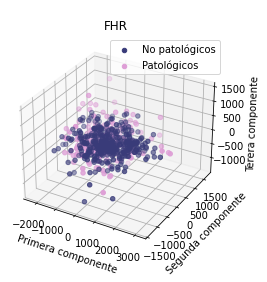

In [24]:
r = scatterThreeDim(save = "scatter highQ", scores_fhr = scores_fhr, target = target, leyend = ['No patológicos', 'Patológicos'], title = ' ', clusters=[0,1])

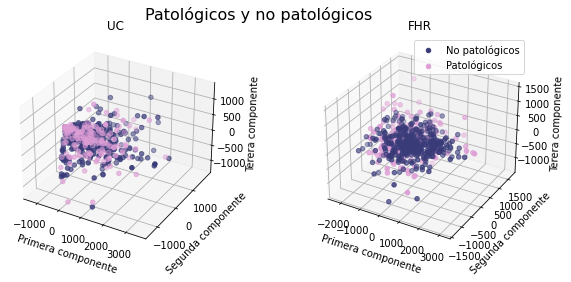

In [28]:
r = scatterThreeDim(save = "scatter highQ", scores_fhr = scores_fhr, target = target, leyend = ['No patológicos', 'Patológicos'], scores_uc = scores_uc, target2 = target2, title = 'Patológicos y no patológicos', clusters=[0,1])

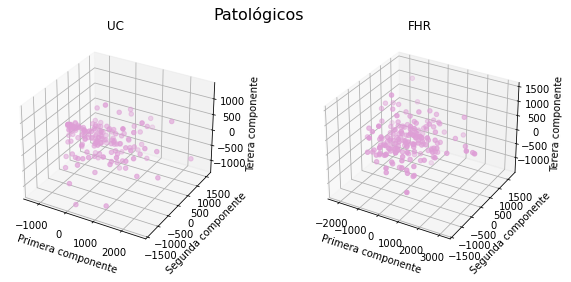

In [29]:
r = scatterThreeDim(scores_fhr, target, leyend = ['No patológicos', 'Patológicos'], quitleyend = True, scores_uc = scores_uc, target2 = target2, title = 'Patológicos', clusters=[1])

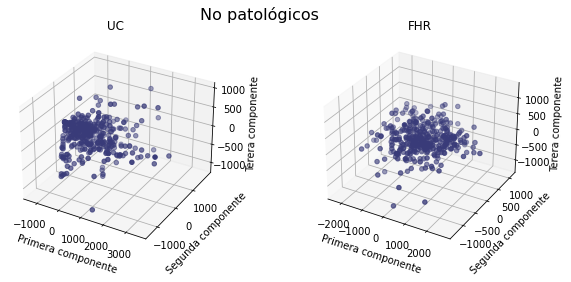

In [30]:
r = scatterThreeDim(scores_fhr, target, leyend = ['No patológicos', 'Patológicos'], quitleyend = True, scores_uc = scores_uc, target2 = target2, title = 'No patológicos', clusters=[0])

Observamos que ambas poblaciones se encuentran extremadamente mezcladas. Esto es algo que ya intuíamos de antemano ya que no son heterogéneas.

Como no obtenemos ningún resultado interesante con tres componentes y tampoco nos describe una proporción de varianza explicada suficiente para tratar los datos con esa dimensionalidad, deducimos que no es apropiado utilizar esta representación. Igualmente investigamos un poco sobre cuál sería un número de componentes que nos de un porcentaje más decente por si computacionalmente nos viniera bien reducir la dimensionalidad a otro número.

In [31]:
''' Función que dados unos datos funcionales, y una proporción de varianza deseada, devuelve el mínimo número de componentes necesarias 
    para aplicar FPCA a los datos y que la proporción de varianza explicada con dichas componentes sea la deseada
    input:
        varianza: numero decimal entre 0 y 1
        data: datos funcionales en Fgrid
        n: número de componentes por el que empezamos a comprobar
    output: número de componentes obtenido
    '''
def calculaComponentes(varianza, data, n=0):
    var = 0
    componentes = n
    while (var<varianza):
        fpca_grid = FPCA(componentes)
        fpca_grid = fpca_grid.fit(data)
        var = sum(fpca_grid.explained_variance_ratio_)
        componentes += 1
    return componentes

In [32]:
calculaComponentes(0.8, fd_uc, n=48)

49

Para una proporción de varianza del 80% (que tampoco es lo deseable totalmente), necesitaríamos 51 componentes. No tiene sentido utilizar FPCA en este caso por tanto descartamos este método de representación y pasamos a otro tipo de análisis.

